# Knowledge Graph Schema Exploration

**Goal**: Test entity extraction and relationship identification on 5 sample paragraphs from Book 3, Chapter 4 (Rome).

**Approach**: 
- Extract ALL entities (approach B - categorize later)
- Use GPT-4o with structured outputs
- Compare with manual annotations
- Iterate on schema and prompts

## Setup

In [1]:
import json
import os
from pathlib import Path
from pydantic import BaseModel, Field
from typing import Optional
from langchain_openai import ChatOpenAI

# Set up OpenAI API key
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not set")

## Load Sample Paragraphs

In [2]:
# Load the 5 selected paragraphs
with open("selected_5_paragraphs.json") as f:
    paragraphs = json.load(f)

print(f"Loaded {len(paragraphs)} paragraphs\n")
for i, p in enumerate(paragraphs, 1):
    print(f"[{i}] Page {p['page']}: {p['text'][:100]}...")

Loaded 5 paragraphs

[1] Page 319: In the sixth century BC the Etruscans were installed in an important bridgehead on the south bank of...
[2] Page 346: Augustus was able to obtain the return of the Roman standards taken from Crassus and thankfully set ...
[3] Page 339: Brilliance like this was not just a matter of winning battles. Brief though Caesar’s recent visits t...
[4] Page 341: This was the end of civil war. Octavian returned to become consul. He had every card in his hand and...
[5] Page 325: The constitutional arrangements of the early republic were thus very complicated, but effective. The...


## Define Schema (Pydantic Models)

In [3]:
class Entity(BaseModel):
    """Extracted entity from historical text (LLM output)."""
    name: str
    type: str  # "person", "place", "collective_entity", "event", "temporal", "cultural"
    subtype: Optional[str] = None  # For place: "city", "region", "river" | collective_entity: "state", "organization", "league" | temporal: "century", "year", "date"
    aliases: list[str] = Field(default_factory=list)
    description: Optional[str] = None
    attributes: Optional[dict[str, str]] = None  # For titles, roles, etc.
    time_range: Optional[list[str, str]] = None  # Will be populated from relationships
    confidence: float = Field(default=1.0, ge=0.0, le=1.0)

class Relationship(BaseModel):
    """Relationship between two entities (LLM output)."""
    source_entity: str  # Entity name
    relation_type: str  # "conquered", "succeeded", "influenced-by", "ruled", "allied-with", etc.
    target_entity: str  # Entity name
    temporal_context: Optional[str] = None  # "509 BC", "6th century BC", "27 BC"
    confidence: float = Field(default=1.0, ge=0.0, le=1.0)

class ExtractionResult(BaseModel):
    """Result of entity extraction from a paragraph."""
    entities: list[Entity]
    relationships: list[Relationship]
    paragraph_id: str

# Post-processed models (with IDs assigned)
class EntityWithId(BaseModel):
    """Entity with UUID assigned after extraction."""
    id: str  # UUID
    name: str
    type: str
    subtype: Optional[str] = None
    aliases: list[str] = Field(default_factory=list)
    description: Optional[str] = None
    attributes: Optional[dict[str, str]] = None
    confidence: float = Field(default=1.0, ge=0.0, le=1.0)
    paragraph_id: str
    relationship_ids: list[str] = Field(default_factory=list)  # Bidirectional link

class RelationshipWithId(BaseModel):
    """Relationship with UUIDs for entities."""
    id: str  # UUID
    source_id: str  # Entity UUID
    target_id: str  # Entity UUID
    relation_type: str
    temporal_context: Optional[str] = None
    confidence: float = Field(default=1.0, ge=0.0, le=1.0)
    paragraph_id: str

# Normalized models (after merging duplicates)
class NormalizedEntity(BaseModel):
    """Normalized entity after merging duplicates."""
    id: str  # Canonical UUID
    name: str
    type: str
    subtype: Optional[str] = None
    aliases: list[str] = Field(default_factory=list)
    description: str  # Combined descriptions
    attributes: Optional[dict[str, str]] = None
    source_paragraph_ids: list[str]
    occurrence_count: int
    merged_from_ids: list[str] = Field(default_factory=list)  # Original entity IDs that merged
    relationship_ids: list[str] = Field(default_factory=list)  # Bidirectional link

class NormalizedRelationship(BaseModel):
    """Normalized relationship with canonical entity IDs."""
    id: str  # UUID (preserved from original)
    source_id: str  # Normalized entity ID
    target_id: str  # Normalized entity ID
    relation_type: str
    temporal_context: Optional[str] = None
    confidence: float
    paragraph_id: str

## Manual Annotations (Reference)

Our manual annotations from Paragraph 1 (Etruscans and Rome's founding):

In [4]:
# Manual annotations for Paragraph 1 (abbreviated - see planning notes for full)
manual_paragraph_1 = {
    "entities": [
        {"name": "Etruscans", "type": "collective_entity", "subtype": "people"},
        {"name": "River Tiber", "type": "place", "subtype": "river", "aliases": ["Tiber"]},
        {"name": "Rome", "type": "place", "subtype": "city"},
        {"name": "Rome", "type": "collective_entity", "subtype": "state"},  # Dual nature!
        {"name": "Latins", "type": "collective_entity", "subtype": "people"},
        {"name": "Campania", "type": "place", "subtype": "region"},
        {"name": "509 BC", "type": "temporal", "subtype": "year"},
        {"name": "sixth century BC", "type": "temporal", "subtype": "century"},
        # ... more entities
    ],
    "relationships": [
        {"source": "Rome", "relation_type": "located-on", "target": "River Tiber"},
        {"source": "Rome", "relation_type": "broke-away-from", "target": "Etruscans", "temporal_context": "509 BC"},
        {"source": "Latin cities", "relation_type": "revolted-against", "target": "Etruscans", "temporal_context": "sixth century BC"},
        # ... more relationships
    ]
}

print("Manual annotations recorded for comparison")

Manual annotations recorded for comparison


## GPT-4o Extraction - Initial Prompt

In [5]:
EXTRACTION_PROMPT = """You are analyzing "The Penguin History of the World", Book 3: The Classical Age, Chapter 4 on Rome.

Extract ALL entities and relationships from the provided paragraph.

**ENTITY TYPES**:
- person: Individuals (rulers, leaders, historical figures)
- place: Geographic locations (cities, regions, rivers, etc.)
- collective_entity: Groups, states, organizations, peoples, leagues
- event: Historical events, political actions, battles, reforms
- temporal: Time references (centuries, years, dates)
- cultural: Cultural concepts, traditions, civilizations

**SUBTYPES**:
- place: "city", "region", "river", "sea"
- collective_entity: "state", "people", "organization", "league"
- temporal: "century" (single century), "year" (single year), "date" (specific date), "range" (time range)

**RELATIONSHIP TYPES** (examples - extract any you find):
- Political: "ruled", "conquered", "allied-with", "subordinated", "revolted-against", "succeeded"
- Geographic: "located-on", "located-in", "bordered-by"
- Cultural: "influenced-by", "came-from", "accessed-through"
- Temporal: "happened-in", "occurred-during"

**IMPORTANT GUIDELINES**:
1. Extract entities FROM THIS PARAGRAPH ONLY - do not use external knowledge
2. Extract relationships that are EXPLICITLY STATED in the text
3. Include aliases if the entity is referred to by multiple names (e.g., "Octavian" also called "Augustus")
4. For titles/roles, store as attributes (e.g., Caesar's "dictator for life")
5. DO NOT extract:
   - Generic unnamed groups ("his men", "the soldiers")
   - Entities mentioned only as comparisons ("like Athens")
   - Vague references without clear identity
6. Include temporal_context in relationships when dates/times are mentioned
7. Note: Some entities may have dual nature (e.g., Rome as both a city and a political state) - extract both if clear from context

Extract entities and relationships from this paragraph:

{paragraph_text}
"""

print("Extraction prompt defined")

Extraction prompt defined


## Test Extraction on Paragraph 1

In [6]:
def extract_entities_gpt(paragraph_text: str, paragraph_id: str, model_name: str = "gpt-4.1") -> ExtractionResult:
    """Extract entities and relationships using GPT-4.1 with LangChain structured outputs."""
    
    # Initialize model with structured output
    if model_name.startswith("gpt-5"):
        model = ChatOpenAI(model=model_name)
    else:
        
        model = ChatOpenAI(model=model_name, temperature=0.0)
    model_with_structure = model.with_structured_output(ExtractionResult)
    
    # Create the prompt
    system_message = "You are an expert at extracting structured historical entities and relationships from text."
    user_message = EXTRACTION_PROMPT.format(paragraph_text=paragraph_text)
    
    # Invoke with LCEL
    result = model_with_structure.invoke([
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}
    ])
    
    result.paragraph_id = paragraph_id
    return result


In [7]:

# Test on first paragraph
para1 = paragraphs[0]
print(f"Extracting from Paragraph 1 (Page {para1['page']})...\n")
print(f"Text preview: {para1['text'][:200]}...\n")

result1 = extract_entities_gpt(para1['text'], para1['id'])

print(f"\n=== EXTRACTION RESULTS ===")
print(f"Entities extracted: {len(result1.entities)}")
print(f"Relationships extracted: {len(result1.relationships)}")

Extracting from Paragraph 1 (Page 319)...

Text preview: In the sixth century BC the Etruscans were installed in an important bridgehead on the south bank of the River Tiber. This was the site of Rome, one of a number of small cities of the Latins, an old-e...


=== EXTRACTION RESULTS ===
Entities extracted: 18
Relationships extracted: 18


## Inspect Extracted Entities

In [8]:
print("\n=== ENTITIES ===")
for i, entity in enumerate(result1.entities, 1):
    print(f"\n[{i}] {entity.name}")
    print(f"    Type: {entity.type}")
    if entity.subtype:
        print(f"    Subtype: {entity.subtype}")
    if entity.aliases:
        print(f"    Aliases: {entity.aliases}")
    if entity.description:
        print(f"    Description: {entity.description[:100]}...")
    if entity.attributes:
        print(f"    Attributes: {entity.attributes}")
    print(f"    Confidence: {entity.confidence}")


=== ENTITIES ===

[1] Etruscans
    Type: collective_entity
    Subtype: people
    Description: A people who were installed in a bridgehead on the south bank of the River Tiber in the sixth centur...
    Confidence: 1.0

[2] River Tiber
    Type: place
    Subtype: river
    Aliases: ['Tiber']
    Description: A river in Italy, on whose south bank the Etruscans were installed....
    Confidence: 1.0

[3] Rome
    Type: place
    Subtype: city
    Description: A city on the south bank of the River Tiber, site of an important bridgehead, and a focus of land an...
    Confidence: 1.0

[4] Rome
    Type: collective_entity
    Subtype: state
    Description: A political entity that broke away from Etruscan dominion and retained much from its Etruscan past....
    Confidence: 1.0

[5] Latins
    Type: collective_entity
    Subtype: people
    Description: An old-established people of the Campania, whose cities included Rome....
    Confidence: 1.0

[6] Campania
    Type: place
    Subtype:

## Inspect Extracted Relationships

In [9]:
print("\n=== RELATIONSHIPS ===")
for i, rel in enumerate(result1.relationships, 1):
    temporal = f" ({rel.temporal_context})" if rel.temporal_context else ""
    print(f"[{i}] {rel.source_entity} --[{rel.relation_type}]--> {rel.target_entity}{temporal}")
    print(f"    Confidence: {rel.confidence}")


=== RELATIONSHIPS ===
[1] Etruscans --[installed-in]--> bridgehead on the south bank of the River Tiber (sixth century BC)
    Confidence: 1.0
[2] bridgehead on the south bank of the River Tiber --[located-in]--> Rome
    Confidence: 1.0
[3] Rome --[located-on]--> River Tiber
    Confidence: 1.0
[4] Rome --[city-of]--> Latins
    Confidence: 1.0
[5] Latins --[located-in]--> Campania
    Confidence: 1.0
[6] Etruscan --[influenced]--> European tradition
    Confidence: 0.8
[7] Rome --[broke-away-from]--> Etruscan dominion (end of the sixth century BC)
    Confidence: 1.0
[8] revolt of the Latin cities --[occurred-during]--> end of the sixth century BC (end of the sixth century BC)
    Confidence: 1.0
[9] Latin cities --[revolted-against]--> Etruscans (end of the sixth century BC)
    Confidence: 1.0
[10] kings of Rome --[ruled]--> Rome (before 509 BC)
    Confidence: 1.0
[11] last king of Rome --[expelled-from]--> Rome (509 BC)
    Confidence: 1.0
[12] Etruscan power --[challenged-by]--

## Compare with Manual Annotations

In [10]:
# Manual comparison - what did LLM miss? What did it over-extract?
print("\n=== COMPARISON NOTES ===")
print("\nManual extraction had these key entities:")
for e in manual_paragraph_1["entities"][:5]:
    print(f"  - {e['name']} ({e['type']})")

print("\nLLM extracted:")
for e in result1.entities[:5]:
    print(f"  - {e.name} ({e.type})")

print("\nQuestions to explore:")
print("- Did LLM capture the dual nature of Rome (city + political entity)?")
print("- Did LLM correctly categorize temporal entities (century vs year)?")
print("- Did LLM avoid extracting generic groups?")
print("- Are relationship types appropriate and specific enough?")


=== COMPARISON NOTES ===

Manual extraction had these key entities:
  - Etruscans (collective_entity)
  - River Tiber (place)
  - Rome (place)
  - Rome (collective_entity)
  - Latins (collective_entity)

LLM extracted:
  - Etruscans (collective_entity)
  - River Tiber (place)
  - Rome (place)
  - Rome (collective_entity)
  - Latins (collective_entity)

Questions to explore:
- Did LLM capture the dual nature of Rome (city + political entity)?
- Did LLM correctly categorize temporal entities (century vs year)?
- Did LLM avoid extracting generic groups?
- Are relationship types appropriate and specific enough?


## Save Extraction Results

In [11]:
# # Save for later analysis
# output = {
#     "paragraph_id": para1['id'],
#     "paragraph_text": para1['text'],
#     "page": para1['page'],
#     "entities": [e.model_dump() for e in result1.entities],
#     "relationships": [r.model_dump() for r in result1.relationships]
# }

# with open("extraction_paragraph1_initial.json", "w") as f:
#     json.dump(output, f, indent=2)

# print("Saved extraction results to extraction_paragraph1_initial.json")

## Iteration Space

Use the cells below to:
1. Refine the extraction prompt
2. Test on other paragraphs
3. Experiment with different entity types or relationship schemas
4. Test normalization approaches (Levenshtein, embeddings)

In [12]:
# Iteration cell - modify prompt and re-run
# TODO: Based on comparison, adjust EXTRACTION_PROMPT and re-extract

EXTRACTION_PROMPT = """You are analyzing text from "The Penguin History of the World".

Extract noteworthy entities and relationships from the provided paragraph.

**ENTITY TYPES**:
- person: Individuals (rulers, leaders, historical figures)
- place: Geographic locations (cities, regions, rivers, etc.)
- collective_entity: Groups, states, organizations, peoples, leagues
- event: Historical events, political actions, battles, reforms
- temporal: Time references (centuries, years, dates)
- cultural: Cultural concepts, traditions, civilizations

**SUBTYPES**:
- place: "city", "region", "river", "sea"
- collective_entity: "state", "people", "organization", "league"
- temporal: "century" (single century), "year" (single year), "date" (specific date), "range" (time range)

**RELATIONSHIP TYPES** (examples - extract any you find):
- Political: "ruled", "conquered", "allied-with", "subordinated", "revolted-against", "succeeded"
- Geographic: "located-on", "located-in", "bordered-by"
- Cultural: "influenced-by", "came-from", "accessed-through"
- Temporal: "happened-in", "occurred-during"

**IMPORTANT GUIDELINES**:
1. Extract entities FROM THIS PARAGRAPH ONLY - do not use external knowledge
2. Extract *noteworthy* entities (think: proper nouns, significant concepts)
3. Extract relationships that are EXPLICITLY STATED in the text
4. Be specific; you may infer details where they are obvious (e.g., "the capital" in the context of Byzantium -> Constantinople)
5. Include aliases if the entity is referred to by multiple names (e.g., "Octavian" also called "Augustus")
6. For titles/roles, store as attributes
7. DO NOT extract:
   - Generic unnamed groups ("his men", "the soldiers")
   - Entities mentioned only as comparisons ("like Athens")
   - Vague references without clear identity
8. Include temporal_context in relationships when dates/times are mentioned
9. Note: Some entities may have dual nature (e.g., Rome as both a city and a political state) - extract both if clear from context
10. Only extract entities if they appear in a relationship, and only extract relationships between extracted entities.

Extract entities and relationships from this paragraph:

{paragraph_text}
"""

In [13]:
# model = "gpt-4.1-nano-2025-04-14"
# label = "4nano_prompt2"
model = "gpt-4.1-mini-2025-04-14"
label = "4mini_prompt3"
# model = "gpt-5-mini-2025-08-07"
# label = "5mini_prompt2"
# model = "gpt-5-nano-2025-08-07"
# label = "5nano_prompt2"


In [14]:

# Test on all 5 paragraphs
all_results = []

for para in paragraphs:
    print(f"\nExtracting from page {para['page']}...")
    result = extract_entities_gpt(para['text'], para['id'], model_name=model)
    all_results.append(result)
    print(f"  Entities: {len(result.entities)}, Relationships: {len(result.relationships)}")

print(f"\nTotal extracted across all paragraphs:")
total_entities = sum(len(r.entities) for r in all_results)
total_relationships = sum(len(r.relationships) for r in all_results)
print(f"  Entities: {total_entities}")
print(f"  Relationships: {total_relationships}")


Extracting from page 319...
  Entities: 10, Relationships: 13

Extracting from page 346...
  Entities: 9, Relationships: 9

Extracting from page 339...
  Entities: 6, Relationships: 5

Extracting from page 341...
  Entities: 6, Relationships: 8

Extracting from page 325...
  Entities: 11, Relationships: 13

Total extracted across all paragraphs:
  Entities: 42
  Relationships: 48


In [15]:
print("\n=== ENTITIES ===")
for result in all_results:
    print(f"\n--- Paragraph ID: {result.paragraph_id} ---")
    for i, entity in enumerate(result.entities, 1):
        print(f"\n[{i}] {entity.name}")
        print(f"    Type: {entity.type}")
        if entity.subtype:
            print(f"    Subtype: {entity.subtype}")
        if entity.aliases:
            print(f"    Aliases: {entity.aliases}")
        if entity.description:
            print(f"    Description: {entity.description}")
        if entity.attributes:
            print(f"    Attributes: {entity.attributes}")
        print(f"    Confidence: {entity.confidence}")


=== ENTITIES ===

--- Paragraph ID: 0cd2eb74-f135-4c54-8d93-7ee75280146a ---

[1] Etruscans
    Type: collective_entity
    Subtype: people
    Description: An ancient people installed on the south bank of the River Tiber in the sixth century BC.
    Confidence: 0.95

[2] River Tiber
    Type: place
    Subtype: river
    Aliases: ['Tiber']
    Description: River on whose south bank the Etruscans were installed.
    Confidence: 0.98

[3] Rome
    Type: place
    Subtype: city
    Description: A city on the south bank of the River Tiber, one of the small cities of the Latins.
    Attributes: {'role': 'city'}
    Confidence: 0.99

[4] Latins
    Type: collective_entity
    Subtype: people
    Description: An old-established people of the Campania, associated with Rome and other small cities.
    Attributes: {'region': 'Campania'}
    Confidence: 0.95

[5] Campania
    Type: place
    Subtype: region
    Description: Region associated with the Latins.
    Confidence: 0.95

[6] Etruscan d

In [16]:
print("\n=== RELATIONSHIPS ===")
for result in all_results:
    print(f"\n--- Paragraph ID: {result.paragraph_id} ---")
    for i, rel in enumerate(result.relationships, 1):
        temporal = f" ({rel.temporal_context})" if rel.temporal_context else ""
        print(f"[{i}] {rel.source_entity} --[{rel.relation_type}]--> {rel.target_entity}{temporal}")
        print(f"    Confidence: {rel.confidence}")


=== RELATIONSHIPS ===

--- Paragraph ID: 0cd2eb74-f135-4c54-8d93-7ee75280146a ---
[1] Etruscans --[located-on]--> River Tiber (6th century BC)
    Confidence: 0.95
[2] Rome --[located-on]--> River Tiber (6th century BC)
    Confidence: 0.98
[3] Rome --[came-from]--> Etruscans (before 509 BC)
    Confidence: 0.9
[4] Rome --[ruled]--> Kings of Rome (before 509 BC)
    Confidence: 0.9
[5] Last king of Rome --[succeeded]--> Kings of Rome (before 509 BC)
    Confidence: 0.85
[6] Latins --[located-in]--> Campania
    Confidence: 0.95
[7] Rome --[located-in]--> Campania
    Confidence: 0.9
[8] Rome --[revolted-against]--> Etruscan dominion (end of 6th century BC)
    Confidence: 0.95
[9] Etruscan dominion --[conquered]--> Rome (before end of 6th century BC)
    Confidence: 0.9
[10] Etruscan dominion --[struggled-with]--> Western Greeks (around 509 BC)
    Confidence: 0.9
[11] Latin peoples --[challenged]--> Etruscan power (around 509 BC)
    Confidence: 0.9
[12] Rome --[accessed-through]--> 

In [17]:
# # export all results
# all_output = []
# for result in all_results:
#     output = {
#         "paragraph_id": result.paragraph_id,
#         "entities": [e.model_dump() for e in result.entities],
#         "relationships": [r.model_dump() for r in result.relationships]
#     }
#     all_output.append(output)
# with open("extraction_all_paragraphs.json", "w") as f:
#     json.dump(all_output, f, indent=2)
# print("Saved all extraction results to extraction_all_paragraphs.json")

In [18]:
# Assign IDs to entities and relationships (post-processing step)
import uuid as uuid_module

def assign_ids_to_extraction_results(all_results: list[ExtractionResult]) -> tuple[list[EntityWithId], list[RelationshipWithId]]:
    """
    Assign UUIDs to entities and relationships, create bidirectional links.
    
    Processes one paragraph at a time for clarity.
    
    Returns:
        (entities_with_ids, relationships_with_ids)
    """
    all_entities_with_ids = []
    all_relationships_with_ids = []
    skipped_relationships = 0
    
    # Process each paragraph
    for result in all_results:
        paragraph_entities = {}  # entity_name -> EntityWithId for this paragraph
        paragraph_relationships = []
        
        # Step 1: Create entities with IDs for this paragraph
        for entity in result.entities:
            entity_id = str(uuid_module.uuid4())
            entity_with_id = EntityWithId(
                id=entity_id,
                name=entity.name,
                type=entity.type,
                subtype=entity.subtype,
                aliases=entity.aliases,
                description=entity.description,
                attributes=entity.attributes,
                confidence=entity.confidence,
                paragraph_id=result.paragraph_id,
                relationship_ids=[]  # Will populate as we process relationships
            )
            paragraph_entities[entity.name] = entity_with_id
        
        # Step 2: Create relationships with IDs and build bidirectional links
        for rel in result.relationships:
            source_entity = paragraph_entities.get(rel.source_entity)
            target_entity = paragraph_entities.get(rel.target_entity)
            
            # Only create relationship if both entities exist
            if source_entity and target_entity:
                rel_id = str(uuid_module.uuid4())
                rel_with_id = RelationshipWithId(
                    id=rel_id,
                    source_id=source_entity.id,
                    target_id=target_entity.id,
                    relation_type=rel.relation_type,
                    temporal_context=rel.temporal_context,
                    confidence=rel.confidence,
                    paragraph_id=result.paragraph_id
                )
                paragraph_relationships.append(rel_with_id)
                
                # Build bidirectional links
                source_entity.relationship_ids.append(rel_id)
                target_entity.relationship_ids.append(rel_id)
            else:
                skipped_relationships += 1
                print(f"Skipped relationship: {rel.source_entity} --[{rel.relation_type}]--> {rel.target_entity} (entities not found)")
                print(f"\tsource entity: {source_entity}")
                print(f"\ttarget entity: {target_entity}")

        
        # Add to global lists
        all_entities_with_ids.extend(paragraph_entities.values())
        all_relationships_with_ids.extend(paragraph_relationships)
    
    print(f"Created {len(all_entities_with_ids)} entities with IDs")
    print(f"Created {len(all_relationships_with_ids)} relationships with IDs")
    print(f"Skipped {skipped_relationships} relationships (referenced entities not found)")
    
    return all_entities_with_ids, all_relationships_with_ids

# Assign IDs
entities_with_ids, relationships_with_ids = assign_ids_to_extraction_results(all_results)

# Verify bidirectional links
entities_with_rels = [e for e in entities_with_ids if e.relationship_ids]
print(f"\nEntities with relationships: {len(entities_with_rels)} / {len(entities_with_ids)}")
if entities_with_rels:
    print(f"Example: '{entities_with_rels[0].name}' has {len(entities_with_rels[0].relationship_ids)} relationships")

Skipped relationship: Latin peoples --[challenged]--> Etruscan power (entities not found)
	source entity: None
	target entity: None
Skipped relationship: Rome --[accessed-through]--> Greek civilization (entities not found)
	source entity: id='ed434aef-c07a-4585-a428-ff152ebb34ad' name='Rome' type='place' subtype='city' aliases=[] description='A city on the south bank of the River Tiber, one of the small cities of the Latins.' attributes={'role': 'city'} confidence=0.99 paragraph_id='0cd2eb74-f135-4c54-8d93-7ee75280146a' relationship_ids=['15142d25-34c2-4017-a515-d4e860b92e58', '9236b268-9f61-42d7-84e1-25c9369cb081', '0d99ad2a-68d5-4765-b7c1-5b6cc16a673d', 'c84e1ecb-0ca1-4cfb-87d0-d43fd6bde415', '856e0ff9-7359-43a2-a9d7-bb3ad8ebac3d', '0288f356-1099-49e4-b691-39d449b6489f', '0ba29443-906a-4587-9b2b-b02bd8118078']
	target entity: None
Skipped relationship: Hadrian --[handed-back]--> conquest (entities not found)
	source entity: id='5b81fffb-a4a5-4274-8940-566c51689a69' name='Hadrian' typ

## Next Steps

1. Review extraction quality
2. Identify patterns in what LLM extracts vs manual annotations
3. Refine prompt based on findings
4. Test entity normalization (Levenshtein for duplicates)
5. Build simple graph visualization with NetworkX/Plotly
6. Iterate until satisfied, then move to production script

# Entity Normalization

Merge duplicate entities across all paragraphs using:

1. **Exact name matching** (case-insensitive) - DONE ✓
   
2. **Alias-based merging** - DONE ✓
   - If entity A's name appears in entity B's alias list, merge them
   - **Canonical name selection** (smart merging):
     - More frequent entity becomes canonical (e.g., "Rome" × 4 beats "Roman power" × 1)
     - If tied, shorter name wins
     - If still tied, alphabetical order
   - Iterates until no more merges possible
   
3. **Fuzzy Levenshtein matching** - DONE ✓
   - Finds pairs with high string similarity (default threshold: 0.90)
   - **Two-phase workflow**:
     - Phase 1: Run without `fuzzy_merge_pairs` → returns candidates for review
     - Phase 2: Run with `fuzzy_merge_pairs` → applies approved merges
   - Same frequency-based canonical name selection

In [118]:
# Entity and relationship normalization functions (ID-based)

from difflib import SequenceMatcher
from collections import defaultdict
import uuid

def levenshtein_similarity(s1: str, s2: str) -> float:
    """Calculate similarity ratio between two strings (0.0 to 1.0)."""
    return SequenceMatcher(None, s1.lower(), s2.lower()).ratio()

def normalize_entities_and_relationships(
    entities_with_ids: list[EntityWithId],
    relationships_with_ids: list[RelationshipWithId],
    fuzzy_threshold: float = 0.90,
    fuzzy_merge_pairs: list = None
) -> tuple[list[NormalizedEntity], list[NormalizedRelationship], Optional[list]]:
    """
    Normalize entities by merging duplicates, update relationships to use normalized IDs.
    
    Returns:
        (normalized_entities, normalized_relationships, fuzzy_candidates or None)
    """
    
    print(f"Starting normalization with {len(entities_with_ids)} entities")
    
    # Stage 1: Group entities by exact name match (case-insensitive)
    exact_groups = defaultdict(list)
    for entity in entities_with_ids:
        key = entity.name.lower().strip()
        exact_groups[key].append(entity)
    
    print(f"Unique names after exact matching: {len(exact_groups)}")
    
    # Stage 2: Alias-based merging
    merged_groups = _alias_based_merging(exact_groups)
    print(f"Unique names after alias-based merging: {len(merged_groups)}")
    
    # Stage 3: Fuzzy matching
    fuzzy_candidates = None
    if fuzzy_merge_pairs:
        merged_groups = _apply_fuzzy_merges(merged_groups, fuzzy_merge_pairs)
        print(f"Unique names after fuzzy matching: {len(merged_groups)}")
    else:
        fuzzy_candidates = _find_fuzzy_match_candidates(merged_groups, fuzzy_threshold)
        print(f"Found {len(fuzzy_candidates)} fuzzy match candidates")
    
    # Stage 4: Create normalized entities and track ID mappings
    normalized_entities = []
    old_id_to_normalized_id = {}  # old entity ID -> normalized entity ID
    
    for name, entity_group in merged_groups.items():
        # Create normalized entity
        canonical_id = str(uuid.uuid4())
        merged_from_ids = [e.id for e in entity_group]
        
        # Aggregate data from all entities in group
        all_aliases = set()
        all_descriptions = []
        all_paragraphs = set()
        all_attributes = {}
        all_relationship_ids = set()
        base_entity = entity_group[0]
        
        for entity in entity_group:
            if entity.aliases:
                all_aliases.update(entity.aliases)
            if entity.description:
                all_descriptions.append(entity.description)
            all_paragraphs.add(entity.paragraph_id)
            if entity.attributes:
                all_attributes.update(entity.attributes)
            all_relationship_ids.update(entity.relationship_ids)
            
            # Track old ID -> normalized ID mapping
            old_id_to_normalized_id[entity.id] = canonical_id
        
        normalized_entity = NormalizedEntity(
            id=canonical_id,
            name=base_entity.name,
            type=base_entity.type,
            subtype=base_entity.subtype,
            aliases=list(all_aliases),
            description=' | '.join(all_descriptions) if all_descriptions else '',
            attributes=all_attributes if all_attributes else None,
            source_paragraph_ids=list(all_paragraphs),
            occurrence_count=len(entity_group),
            merged_from_ids=merged_from_ids,
            relationship_ids=list(all_relationship_ids)  # Will update after normalizing relationships
        )
        normalized_entities.append(normalized_entity)
    
    print(f"Created {len(normalized_entities)} normalized entities")
    
    # Stage 5: Normalize relationships (update entity IDs, rebuild bidirectional links)
    normalized_relationships = []
    normalized_entity_id_to_obj = {e.id: e for e in normalized_entities}
    
    # Reset relationship_ids on normalized entities (will rebuild)
    for entity in normalized_entities:
        entity.relationship_ids = []
    
    for rel in relationships_with_ids:
        # Map old entity IDs to normalized IDs
        norm_source_id = old_id_to_normalized_id.get(rel.source_id)
        norm_target_id = old_id_to_normalized_id.get(rel.target_id)
        
        if norm_source_id and norm_target_id:
            # Create normalized relationship
            norm_rel = NormalizedRelationship(
                id=rel.id,  # Preserve original relationship ID
                source_id=norm_source_id,
                target_id=norm_target_id,
                relation_type=rel.relation_type,
                temporal_context=rel.temporal_context,
                confidence=rel.confidence,
                paragraph_id=rel.paragraph_id
            )
            normalized_relationships.append(norm_rel)
            
            # Rebuild bidirectional links
            if norm_source_id in normalized_entity_id_to_obj:
                normalized_entity_id_to_obj[norm_source_id].relationship_ids.append(rel.id)
            if norm_target_id in normalized_entity_id_to_obj:
                normalized_entity_id_to_obj[norm_target_id].relationship_ids.append(rel.id)
    
    print(f"Normalized {len(normalized_relationships)} relationships")
    print(f"Skipped {len(relationships_with_ids) - len(normalized_relationships)} relationships (entities not found)")
    
    return normalized_entities, normalized_relationships, fuzzy_candidates

def _alias_based_merging(exact_groups: dict) -> dict:
    """Merge entity groups if one group's name appears in another group's aliases."""
    merged_groups = dict(exact_groups)
    
    # Build alias lookup
    alias_to_canonical = {}
    for canonical_name, entities in merged_groups.items():
        for entity in entities:
            if entity.aliases:
                for alias in entity.aliases:
                    alias_key = alias.lower().strip()
                    if alias_key and alias_key != canonical_name:
                        alias_to_canonical[alias_key] = canonical_name
    
    print(f"  Found {len(alias_to_canonical)} alias mappings")
    
    # Merge based on aliases (with frequency-based canonical selection)
    merged_any = True
    merge_count = 0
    
    while merged_any:
        merged_any = False
        for name in list(merged_groups.keys()):
            if name not in merged_groups:
                continue
            
            if name in alias_to_canonical:
                other_name = alias_to_canonical[name]
                if other_name in merged_groups and other_name != name:
                    # Frequency-based canonical selection
                    name_count = len(merged_groups[name])
                    other_count = len(merged_groups[other_name])
                    
                    if name_count > other_count:
                        canonical, merge_from = name, other_name
                    elif other_count > name_count:
                        canonical, merge_from = other_name, name
                    else:
                        canonical = name if len(name) < len(other_name) else other_name
                        merge_from = other_name if canonical == name else name
                    
                    merged_groups[canonical].extend(merged_groups[merge_from])
                    del merged_groups[merge_from]
                    merged_any = True
                    merge_count += 1
                    print(f"  Merged '{merge_from}' into '{canonical}'")
                    
                    # Rebuild alias lookup
                    alias_to_canonical = {}
                    for canonical_name, entities in merged_groups.items():
                        for entity in entities:
                            if entity.aliases:
                                for alias in entity.aliases:
                                    alias_key = alias.lower().strip()
                                    if alias_key and alias_key != canonical_name:
                                        alias_to_canonical[alias_key] = canonical_name
                    break
    
    print(f"  Completed {merge_count} alias-based merges")
    return merged_groups

def _find_fuzzy_match_candidates(merged_groups: dict, threshold: float) -> list:
    """Find pairs of entity groups with high string similarity."""
    candidates = []
    group_names = list(merged_groups.keys())
    
    for i, name1 in enumerate(group_names):
        for name2 in group_names[i+1:]:
            similarity = levenshtein_similarity(name1, name2)
            if similarity >= threshold:
                group1 = merged_groups[name1]
                group2 = merged_groups[name2]
                entity1 = group1[0]
                entity2 = group2[0]
                
                candidates.append({
                    'name1': name1,
                    'name2': name2,
                    'similarity': similarity,
                    'count1': len(group1),
                    'count2': len(group2),
                    'type1': entity1.type,
                    'type2': entity2.type,
                })
    
    candidates.sort(key=lambda x: x['similarity'], reverse=True)
    return candidates

def _apply_fuzzy_merges(merged_groups: dict, merge_pairs: list) -> dict:
    """Apply approved fuzzy matches."""
    result = dict(merged_groups)
    
    for name1, name2 in merge_pairs:
        if name1 not in result or name2 not in result:
            continue
        
        # Frequency-based canonical selection
        count1 = len(result[name1])
        count2 = len(result[name2])
        canonical = name1 if count1 >= count2 else name2
        merge_from = name2 if canonical == name1 else name1
        
        result[canonical].extend(result[merge_from])
        del result[merge_from]
        print(f"  Merged '{merge_from}' into '{canonical}' (fuzzy match)")
    
    return result

print("Entity and relationship normalization functions defined")

Entity and relationship normalization functions defined


## Test Normalization

Run normalization on all 5 paragraphs and inspect results

In [120]:
# Run normalization on entities and relationships
normalized_entities, normalized_relationships, fuzzy_candidates = normalize_entities_and_relationships(
    entities_with_ids, 
    relationships_with_ids,
    fuzzy_threshold=0.90
)

# Print statistics
print("\n" + "=" * 80)
print("NORMALIZATION STATISTICS")
print("=" * 80)
print(f"Total entities before: {len(entities_with_ids)}")
print(f"Normalized entities: {len(normalized_entities)}")
print(f"Reduction: {len(entities_with_ids) - len(normalized_entities)} entities merged")
print()
print(f"Total relationships before: {len(relationships_with_ids)}")
print(f"Normalized relationships: {len(normalized_relationships)}")
print(f"Skipped: {len(relationships_with_ids) - len(normalized_relationships)} relationships")
print()

# Display top 10 most frequently occurring entities
print("=" * 80)
print("TOP 10 MOST FREQUENT ENTITIES")
print("=" * 80)
sorted_entities = sorted(normalized_entities, key=lambda x: x.occurrence_count, reverse=True)

for i, entity in enumerate(sorted_entities[:10], 1):
    print(f"\n[{i}] {entity.name} ({entity.type})")
    print(f"    Occurrences: {entity.occurrence_count}")
    print(f"    Merged from {len(entity.merged_from_ids)} entities")
    print(f"    Relationships: {len(entity.relationship_ids)}")
    if entity.aliases:
        print(f"    Aliases: {', '.join(entity.aliases[:3])}")
    if entity.attributes:
        print(f"    Attributes: {entity.attributes}")

print("\n" + "=" * 80)

Starting normalization with 44 entities
Unique names after exact matching: 40
  Found 9 alias mappings
  Merged 'roman power' into 'rome'
  Merged 'augustus' into 'octavian'
  Completed 2 alias-based merges
Unique names after alias-based merging: 38
Found 0 fuzzy match candidates
Created 38 normalized entities
Normalized 31 relationships
Skipped 0 relationships (entities not found)

NORMALIZATION STATISTICS
Total entities before: 44
Normalized entities: 38
Reduction: 6 entities merged

Total relationships before: 31
Normalized relationships: 31
Skipped: 0 relationships

TOP 10 MOST FREQUENT ENTITIES

[1] Rome (place)
    Occurrences: 5
    Merged from 5 entities
    Relationships: 13
    Aliases: Rome
    Attributes: {'role': 'city'}

[2] Senate (collective_entity)
    Occurrences: 2
    Merged from 2 entities
    Relationships: 2

[3] Octavian (person)
    Occurrences: 2
    Merged from 2 entities
    Relationships: 5
    Aliases: princeps, Augustus
    Attributes: {'titles_roles': 'c

In [121]:
# # Display sample entity mappings to verify normalization
# print("=" * 80)
# print("SAMPLE ENTITY MAPPINGS (first 15)")
# print("=" * 80)
# print("Format: (paragraph_id, entity_name) -> normalized_entity_id")
# print()

# for i, ((para_id, entity_name), norm_id) in enumerate(list(normalized_data['entity_mapping'].items())[:15], 1):
#     # Find the normalized entity to show its canonical name
#     norm_entity = next(e for e in normalized_data['normalized_entities'] if e['id'] == norm_id)
#     print(f"[{i}] ({para_id[:8]}..., '{entity_name}') -> {norm_entity['name']}")
#     if entity_name.lower() != norm_entity['name'].lower():
#         print(f"     NOTE: Name normalized from '{entity_name}' to '{norm_entity['name']}'")

# print("\n" + "=" * 80)

## Review Fuzzy Match Candidates

If fuzzy candidates were found, review them before applying merges

In [122]:
# # Display fuzzy match candidates if any were found
# if 'fuzzy_candidates' in normalized_data and normalized_data['fuzzy_candidates']:
#     candidates = normalized_data['fuzzy_candidates']
    
#     print("=" * 100)
#     print(f"FUZZY MATCH CANDIDATES (found {len(candidates)} pairs)")
#     print("=" * 100)
#     print()
    
#     for i, candidate in enumerate(candidates, 1):
#         print(f"[{i}] Similarity: {candidate['similarity']:.3f}")
#         print(f"    '{candidate['name1']}' ({candidate['type1']}/{candidate['subtype1']}) × {candidate['count1']}")
#         print(f"    '{candidate['name2']}' ({candidate['type2']}/{candidate['subtype2']}) × {candidate['count2']}")
#         print()
    
#     print("=" * 100)
#     print("\nTo apply merges, create a list of approved pairs:")
#     print("approved_merges = [")
#     print("    ('name1', 'name2'),")
#     print("    ('name3', 'name4'),")
#     print("]")
#     print("\nThen re-run normalization with:")
#     print("normalized_data = normalize_entities(all_results, fuzzy_merge_pairs=approved_merges)")
# else:
#     print("No fuzzy candidates found (or fuzzy merges already applied)")

## Apply Approved Fuzzy Merges

After reviewing candidates, apply selected merges

In [123]:
# Example: Apply fuzzy merges after review
# Uncomment and modify this to apply selected merges

# approved_merges = [
#     ('entity1', 'entity2'),  # Replace with actual entity names from candidates above
#     # Add more pairs as needed
# ]

# # Re-run normalization with approved merges
# normalized_data = normalize_entities(all_results, fuzzy_merge_pairs=approved_merges)

# # Display updated statistics
# print("\n" + "=" * 80)
# print("FINAL NORMALIZATION STATISTICS")
# print("=" * 80)
# print(f"Total entities extracted: {sum(len(r.entities) for r in all_results)}")
# print(f"Final normalized entities: {len(normalized_data['normalized_entities'])}")
# print(f"Total reduction: {sum(len(r.entities) for r in all_results) - len(normalized_data['normalized_entities'])} duplicates merged")

print("Ready to apply fuzzy merges - uncomment and modify the code above")

Ready to apply fuzzy merges - uncomment and modify the code above


In [124]:
import networkx as nx

def build_knowledge_graph(
    normalized_entities: list[NormalizedEntity],
    normalized_relationships: list[NormalizedRelationship]
) -> nx.DiGraph:
    """
    Build a directed graph from normalized entities and relationships.
    
    Args:
        normalized_entities: List of NormalizedEntity objects
        normalized_relationships: List of NormalizedRelationship objects
    
    Returns:
        NetworkX DiGraph with entity nodes and relationship edges
    """
    G = nx.DiGraph()
    
    # Add nodes for each normalized entity
    for entity in normalized_entities:
        G.add_node(
            entity.id,
            name=entity.name,
            type=entity.type,
            subtype=entity.subtype,
            aliases=entity.aliases,
            description=entity.description,
            attributes=entity.attributes,
            occurrence_count=entity.occurrence_count,
            source_paragraphs=entity.source_paragraph_ids,
            relationship_count=len(entity.relationship_ids)
        )
    
    print(f"Added {G.number_of_nodes()} nodes to graph")
    
    # Add edges for relationships
    for rel in normalized_relationships:
        if rel.source_id in G and rel.target_id in G:
            # Check if edge already exists (from another relationship)
            if G.has_edge(rel.source_id, rel.target_id):
                # Aggregate relation types
                edge_data = G[rel.source_id][rel.target_id]
                if rel.relation_type not in edge_data.get('relation_types', []):
                    edge_data.setdefault('relation_types', []).append(rel.relation_type)
            else:
                # New edge
                G.add_edge(
                    rel.source_id,
                    rel.target_id,
                    relation_id=rel.id,
                    relation_type=rel.relation_type,
                    relation_types=[rel.relation_type],
                    temporal_context=rel.temporal_context,
                    confidence=rel.confidence,
                    source_paragraph=rel.paragraph_id
                )
    
    print(f"Added {G.number_of_edges()} edges to graph")
    
    return G

# Build the graph
kg = build_knowledge_graph(normalized_entities, normalized_relationships)

# Display graph statistics
print("\n" + "=" * 80)
print("KNOWLEDGE GRAPH STATISTICS")
print("=" * 80)
print(f"Nodes (entities): {kg.number_of_nodes()}")
print(f"Edges (relationships): {kg.number_of_edges()}")
if kg.number_of_nodes() > 0:
    print(f"Average degree: {sum(dict(kg.degree()).values()) / kg.number_of_nodes():.2f}")
    print(f"Density: {nx.density(kg):.3f}")
print()

# Top 5 most connected entities
if kg.number_of_nodes() > 0:
    degree_centrality = nx.degree_centrality(kg)
    top_entities = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print("Top 5 most connected entities:")
    for entity_id, centrality in top_entities:
        entity_data = kg.nodes[entity_id]
        print(f"  {entity_data['name']} ({entity_data['type']}): {kg.degree(entity_id)} connections")

print("=" * 80)

Added 38 nodes to graph
Added 31 edges to graph

KNOWLEDGE GRAPH STATISTICS
Nodes (entities): 38
Edges (relationships): 31
Average degree: 1.63
Density: 0.022

Top 5 most connected entities:
  Rome (place): 13 connections
  Octavian (person): 5 connections
  Caesar (person): 4 connections
  Etruscans (collective_entity): 3 connections
  Trajan (person): 3 connections


# Graph Construction

Build knowledge graph with NetworkX using normalized entities and relationships

In [125]:
import plotly.graph_objects as go
import numpy as np

def visualize_knowledge_graph(G: nx.DiGraph, width: int = 1200, height: int = 800):
    """
    Create an interactive Plotly visualization of the knowledge graph.
    
    Args:
        G: NetworkX DiGraph
        width: Figure width in pixels
        height: Figure height in pixels
    """
    # Compute layout using spring layout
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    
    # Define colors for each entity type
    type_colors = {
        'person': '#FF6B6B',        # Red
        'place': '#4ECDC4',         # Teal
        'collective_entity': '#45B7D1',  # Blue
        'event': '#FFA07A',         # Light orange
        'temporal': '#98D8C8',      # Mint
        'cultural': '#C7CEEA',      # Lavender
    }
    
    # Create edge traces
    edge_traces = []
    for edge in G.edges():
        source_id, target_id = edge
        x0, y0 = pos[source_id]
        x1, y1 = pos[target_id]
        
        # Create edge line
        edge_trace = go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            mode='lines',
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            showlegend=False
        )
        edge_traces.append(edge_trace)
    
    # Create node trace
    node_x = []
    node_y = []
    node_text = []
    node_colors = []
    node_sizes = []
    
    for node_id in G.nodes():
        x, y = pos[node_id]
        node_x.append(x)
        node_y.append(y)
        
        # Get node data
        node_data = G.nodes[node_id]
        name = node_data['name']
        entity_type = node_data['type']
        subtype = node_data.get('subtype', '')
        occurrence_count = node_data['occurrence_count']
        
        # Node color by type
        node_colors.append(type_colors.get(entity_type, '#CCCCCC'))
        
        # Node size by occurrence count (scaled)
        node_sizes.append(10 + (occurrence_count * 5))
        
        # Hover text
        hover_text = f"<b>{name}</b><br>"
        hover_text += f"Type: {entity_type}"
        if subtype:
            hover_text += f" ({subtype})"
        hover_text += f"<br>Occurrences: {occurrence_count}"
        hover_text += f"<br>Connections: {G.degree(node_id)}"
        
        if node_data.get('attributes'):
            hover_text += f"<br>Attributes: {node_data['attributes']}"
        
        node_text.append(hover_text)
    
    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode='markers+text',
        text=[G.nodes[node_id]['name'] for node_id in G.nodes()],
        textposition='top center',
        textfont=dict(size=8),
        hovertext=node_text,
        hoverinfo='text',
        marker=dict(
            size=node_sizes,
            color=node_colors,
            line=dict(width=1, color='white')
        ),
        showlegend=False
    )
    
    # Create legend traces (one per entity type)
    legend_traces = []
    for entity_type, color in type_colors.items():
        legend_trace = go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(size=10, color=color),
            name=entity_type,
            showlegend=True
        )
        legend_traces.append(legend_trace)
    
    # Create figure
    fig = go.Figure(
        data=edge_traces + [node_trace] + legend_traces,
        layout=go.Layout(
            title=dict(
                text="Knowledge Graph: Rome Chapter (Book 3, Chapter 4)",
                font=dict(size=20)
            ),
            showlegend=True,
            hovermode='closest',
            margin=dict(b=20, l=5, r=5, t=40),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            width=width,
            height=height,
            plot_bgcolor='#F8F9FA'
        )
    )
    
    return fig

# Create and display the visualization
fig = visualize_knowledge_graph(kg, width=1400, height=900)
fig.show()

print("\nVisualization tips:")
print("- Hover over nodes to see entity details")
print("- Node size = occurrence count")
print("- Node color = entity type (see legend)")
print("- Drag to pan, scroll to zoom")
print("- Click legend items to show/hide entity types")


Visualization tips:
- Hover over nodes to see entity details
- Node size = occurrence count
- Node color = entity type (see legend)
- Drag to pan, scroll to zoom
- Click legend items to show/hide entity types


# Interactive Graph Visualization

Visualize the knowledge graph with Plotly for interactive exploration

In [126]:
from pyvis.network import Network

def visualize_with_pyvis(
    G: nx.DiGraph,
    normalized_entities: list[NormalizedEntity],
    normalized_relationships: list[NormalizedRelationship],
    output_file: str = "knowledge_graph.html",
    height: str = "900px",
    width: str = "100%"
):
    """
    Create interactive PyVis visualization.
    
    Args:
        G: NetworkX DiGraph
        normalized_entities: List of NormalizedEntity objects
        normalized_relationships: List of NormalizedRelationship objects
        output_file: HTML file to save
        height: Canvas height
        width: Canvas width
    """
    # Create PyVis network
    net = Network(
        height=height,
        width=width,
        directed=True,
        notebook=True,
        bgcolor="#F8F9FA",
        font_color="#333333"
    )
    
    # Configure physics for better layout
    net.set_options("""
    {
        "physics": {
            "enabled": true,
            "forceAtlas2Based": {
                "gravitationalConstant": -50,
                "centralGravity": 0.01,
                "springLength": 200,
                "springConstant": 0.08
            },
            "maxVelocity": 50,
            "solver": "forceAtlas2Based",
            "timestep": 0.35,
            "stabilization": {"iterations": 150}
        },
        "interaction": {
            "hover": true,
            "tooltipDelay": 100,
            "navigationButtons": true,
            "keyboard": true
        }
    }
    """)
    
    # Define colors for entity types
    type_colors = {
        'person': '#FF6B6B',
        'place': '#4ECDC4',
        'collective_entity': '#45B7D1',
        'event': '#FFA07A',
        'temporal': '#98D8C8',
        'cultural': '#C7CEEA',
    }
    
    # Create entity ID lookup
    entity_lookup = {e.id: e for e in normalized_entities}
    
    # Add nodes
    for entity in normalized_entities:
        color = type_colors.get(entity.type, '#CCCCCC')
        size = 15 + (entity.occurrence_count * 5)
        
        # Build title (hover text)
        title = f"<b>{entity.name}</b><br>"
        title += f"Type: {entity.type}"
        if entity.subtype:
            title += f" ({entity.subtype})"
        title += f"<br>Occurrences: {entity.occurrence_count}"
        title += f"<br>Relationships: {len(entity.relationship_ids)}"
        if entity.aliases:
            title += f"<br>Aliases: {', '.join(entity.aliases[:3])}"
        if entity.attributes:
            title += f"<br>Attributes: {entity.attributes}"
        
        net.add_node(
            entity.id,
            label=entity.name,
            title=title,
            color=color,
            size=size,
            font={'size': 14}
        )
    
    # Add edges with labels
    for rel in normalized_relationships:
        if rel.source_id in entity_lookup and rel.target_id in entity_lookup:
            # Create edge label and title
            label = rel.relation_type.replace('-', ' ').replace('_', ' ')
            title = f"{entity_lookup[rel.source_id].name} → {entity_lookup[rel.target_id].name}<br>"
            title += f"Relationship: {rel.relation_type}"
            if rel.temporal_context:
                title += f"<br>When: {rel.temporal_context}"
                label += f" ({rel.temporal_context})"
            
            net.add_edge(
                rel.source_id,
                rel.target_id,
                label=label,
                title=title,
                arrows='to',
                color={'color': '#888888', 'highlight': '#333333'},
                width=2,
                font={'size': 10, 'align': 'middle'}
            )
    
    # Save
    net.save_graph(output_file)
    print(f"✅ Interactive graph saved to: {output_file}")
    print("\nFeatures:")
    print("  • Drag nodes to rearrange")
    print("  • Click node to highlight connections")
    print("  • Hover over nodes/edges for details")
    print("  • Scroll to zoom, drag canvas to pan")
    print("  • Use navigation buttons (bottom right)")
    
    return net

# Create PyVis visualization
net = visualize_with_pyvis(kg, normalized_entities, normalized_relationships)
net.show(f"knowledge_graph_{label}.html")

✅ Interactive graph saved to: knowledge_graph.html

Features:
  • Drag nodes to rearrange
  • Click node to highlight connections
  • Hover over nodes/edges for details
  • Scroll to zoom, drag canvas to pan
  • Use navigation buttons (bottom right)
knowledge_graph_4mini_prompt3.html


# PyVis Visualization (Alternative)

PyVis creates an interactive HTML visualization with:
- **Drag nodes** to rearrange layout
- **Click node** to highlight its connections  
- **Hover** to see entity/relationship details
- **Edge labels** showing relationship types
- **Physics simulation** for organic layout

# Semantic Normalization Experiment

**Problem**: Alias-based merging has limitations (e.g., "Julius Caesar" and "Augustus" both have alias "Caesar" and get incorrectly merged).

**Approach**: Use embedding-based semantic similarity to find merge candidates:
1. Embed each entity (name + type + description)
2. Calculate cosine similarity between all pairs
3. Filter candidates above threshold (e.g., 0.85)
4. (Future) Feed candidates to LLM for final decision

This experiment uses entities with IDs from the 5 test paragraphs.

In [19]:
# Cell 47: Import libraries and prepare entity data
from langchain_openai import OpenAIEmbeddings
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Initialize embeddings
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Use entities_with_ids from the 5 test paragraphs (already created in cell 27)
print(f"Working with {len(entities_with_ids)} entities")
print(f"\nSample entities:")
for entity in entities_with_ids[:3]:
    print(f"  - {entity.name} ({entity.type}): {entity.description[:60] if entity.description else 'No description'}...")


Working with 42 entities

Sample entities:
  - Etruscans (collective_entity): An ancient people installed on the south bank of the River T...
  - River Tiber (place): River on whose south bank the Etruscans were installed....
  - Rome (place): A city on the south bank of the River Tiber, one of the smal...


In [20]:
# Cell 48: Create entity embeddings
def create_entity_text(entity: EntityWithId) -> str:
    """Create text representation of entity for embedding."""
    parts = [
        f"Name: {entity.name}",
        f"Type: {entity.type}",
    ]
    
    if entity.subtype:
        parts.append(f"Subtype: {entity.subtype}")
    
    if entity.description:
        parts.append(f"Description: {entity.description}")
    
    if entity.aliases:
        parts.append(f"Aliases: {', '.join(entity.aliases)}")
    
    return " | ".join(parts)

# Create text representations
entity_texts = [create_entity_text(e) for e in entities_with_ids]

print("Sample entity text representations:")
for i, text in enumerate(entity_texts[:3]):
    print(f"\n[{i+1}] {text[:150]}...")

# Embed all entities
print(f"\n\nEmbedding {len(entity_texts)} entities...")
entity_embeddings = embeddings_model.embed_documents(entity_texts)
entity_embeddings_array = np.array(entity_embeddings)

print(f"✓ Created embeddings with shape: {entity_embeddings_array.shape}")
print(f"  - {entity_embeddings_array.shape[0]} entities")
print(f"  - {entity_embeddings_array.shape[1]} dimensions")


Sample entity text representations:

[1] Name: Etruscans | Type: collective_entity | Subtype: people | Description: An ancient people installed on the south bank of the River Tiber in the six...

[2] Name: River Tiber | Type: place | Subtype: river | Description: River on whose south bank the Etruscans were installed. | Aliases: Tiber...

[3] Name: Rome | Type: place | Subtype: city | Description: A city on the south bank of the River Tiber, one of the small cities of the Latins....


Embedding 42 entities...
✓ Created embeddings with shape: (42, 1536)
  - 42 entities
  - 1536 dimensions


In [21]:
# Cell 49: Calculate cosine similarities between all entity pairs
# Calculate pairwise cosine similarities
similarity_matrix = cosine_similarity(entity_embeddings_array)

print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"\nSample similarities (first entity vs others):")
for i in range(min(5, len(entities_with_ids))):
    sim = similarity_matrix[0, i]
    entity = entities_with_ids[i]
    print(f"  {entities_with_ids[0].name} <-> {entity.name}: {sim:.3f}")

# Find all high-similarity pairs (excluding self-similarities)
similarity_threshold = 0.6
candidates = []

for i in range(len(entities_with_ids)):
    for j in range(i + 1, len(entities_with_ids)):  # Only upper triangle, avoid duplicates
        sim = similarity_matrix[i, j]
        if sim >= similarity_threshold:
            candidates.append({
                'entity1': entities_with_ids[i],
                'entity2': entities_with_ids[j],
                'similarity': sim,
                'i': i,
                'j': j
            })

# Sort by similarity (descending)
candidates.sort(key=lambda x: x['similarity'], reverse=True)

print(f"\n\nFound {len(candidates)} candidate pairs with similarity >= {similarity_threshold}")


Similarity matrix shape: (42, 42)

Sample similarities (first entity vs others):
  Etruscans <-> Etruscans: 1.000
  Etruscans <-> River Tiber: 0.691
  Etruscans <-> Rome: 0.561
  Etruscans <-> Latins: 0.618
  Etruscans <-> Campania: 0.433


Found 61 candidate pairs with similarity >= 0.6


In [22]:
# Cell 50: Display top similarity candidates
print("=" * 100)
print("TOP ENTITY SIMILARITY CANDIDATES")
print("=" * 100)

for idx, candidate in enumerate(candidates[:100], 1):  # Show top 100
    e1 = candidate['entity1']
    e2 = candidate['entity2']
    sim = candidate['similarity']
    
    print(f"\n[{idx}] Similarity: {sim:.4f}")
    print(f"    Entity 1: {e1.name} ({e1.type})")
    if e1.subtype:
        print(f"              Subtype: {e1.subtype}")
    if e1.description:
        print(f"              Desc: {e1.description[:80]}...")
    if e1.aliases:
        print(f"              Aliases: {e1.aliases}")
    
    print(f"    Entity 2: {e2.name} ({e2.type})")
    if e2.subtype:
        print(f"              Subtype: {e2.subtype}")
    if e2.description:
        print(f"              Desc: {e2.description[:80]}...")
    if e2.aliases:
        print(f"              Aliases: {e2.aliases}")
    
    print(f"    ---")

print("\n" + "=" * 100)

# Statistics
if candidates:
    similarities = [c['similarity'] for c in candidates]
    print(f"\nSimilarity statistics:")
    print(f"  Count: {len(candidates)}")
    print(f"  Min: {min(similarities):.4f}")
    print(f"  Max: {max(similarities):.4f}")
    print(f"  Mean: {np.mean(similarities):.4f}")
    print(f"  Median: {np.median(similarities):.4f}")


TOP ENTITY SIMILARITY CANDIDATES

[1] Similarity: 0.8581
    Entity 1: Rome (place)
              Subtype: city
              Desc: Capital city where Caesar had organized political support and packed the Senate....
    Entity 2: Rome (place)
              Subtype: city
              Desc: The city which was the center of the Roman Republic....
    ---

[2] Similarity: 0.8399
    Entity 1: Rome (place)
              Subtype: city
              Desc: Capital city where Caesar had organized political support and packed the Senate....
    Entity 2: Rome (place)
              Subtype: city
              Desc: Capital city where Octavian was formally called by his family name and identifie...
    ---

[3] Similarity: 0.8091
    Entity 1: Rome (place)
              Subtype: city
              Desc: A city on the south bank of the River Tiber, one of the small cities of the Lati...
    Entity 2: Rome (place)
              Subtype: city
              Desc: The city which was the center of the 

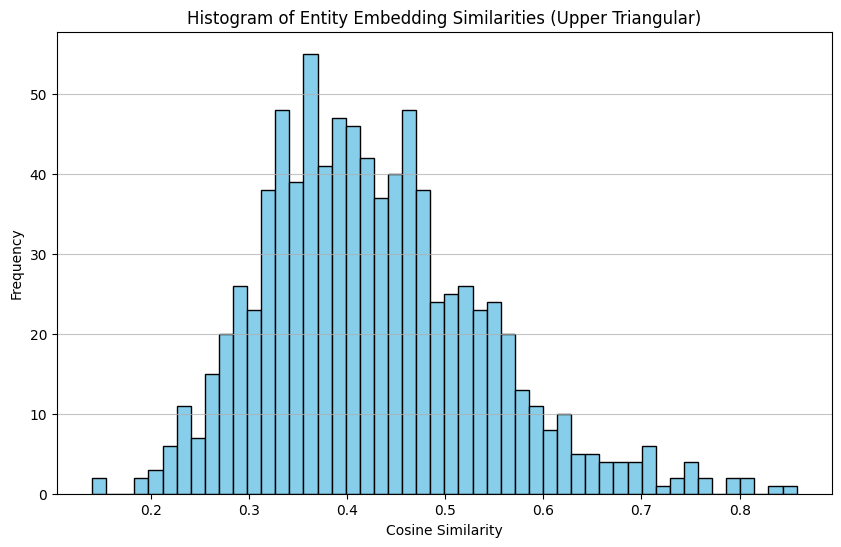

In [23]:
# get upper triangular (no diagonals)
upper_triangular = np.triu(similarity_matrix, k=1)
#flatten to array
flattened_upper = upper_triangular.flatten()
# plot histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.hist(flattened_upper[flattened_upper > 0], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Entity Embedding Similarities (Upper Triangular)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [24]:
len(flattened_upper)

1764

# LLM-Based Semantic Merging Experiment

Test using gpt-4.1-nano to make merge decisions instead of rule-based matching.

**Approach:**
1. Use embedding similarity candidates (from cells 47-50)
2. For each candidate pair, ask LLM: "Are these the same entity?"
3. If yes, let LLM generate the merged entity
4. Compare results to rule-based normalization

In [25]:
# Cell 52: Define LLM merge chain and helper functions
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from typing import Optional
import uuid as uuid_module

# Define output model
class EntityMergeDecision(BaseModel):
    """LLM decision on whether two entities should be merged."""
    reasoning: str = Field(description="Brief explanation of the decision")
    confidence: float = Field(ge=0.0, le=1.0, description="Confidence in the decision")
    should_merge: bool = Field(description="True if entities refer to the same historical entity")
    merged_entity: Optional[EntityWithId] = Field(
        default=None,
        description="The merged entity if should_merge=True, otherwise None"
    )

# Prompt template
# # specific
# ENTITY_MERGE_PROMPT = """You are an expert historian analyzing entity mentions from "The Penguin History of the World".

# Given two entities extracted from different paragraphs, determine if they refer to the SAME historical entity.

# **Entity 1:**
# Name: {entity1_name}
# Type: {entity1_type}
# Subtype: {entity1_subtype}
# Aliases: {entity1_aliases}
# Description: {entity1_description}
# Attributes: {entity1_attributes}
# Confidence: {entity1_confidence}

# **Entity 2:**
# Name: {entity2_name}
# Type: {entity2_type}
# Subtype: {entity2_subtype}
# Aliases: {entity2_aliases}
# Description: {entity2_description}
# Attributes: {entity2_attributes}
# Confidence: {entity2_confidence}

# **Instructions:**
# 1. Determine if these refer to the SAME historical entity (person, place, organization, etc.)
# 2. Consider:
#    - Are the names referring to the same entity? (e.g., "Octavian" and "Augustus" are the same person)
#    - Do the types/subtypes match or are compatible?
#    - Do descriptions align or contradict?
#    - Are attributes consistent?
# 3. If they should be merged:
#    - Choose the most canonical/common name
#    - Write a consolidated description (combine key information, ~2-3 sentences)
#    - Merge aliases (include both original names if not already aliases)
#    - Combine attributes (later values override if conflict)
#    - Set confidence as average of both entities

# **Decision Guidelines:**
# - Different people with same last name (e.g., "Julius Caesar" vs "Augustus Caesar") → DO NOT merge
# - Same person at different life stages (e.g., "Octavian" vs "Augustus") → MERGE
# - Same place in different contexts (e.g., "Rome" the city vs "Rome" the empire) → DO NOT merge (different subtypes)
# - Obvious typos or variations (e.g., "Byzanthium" vs "Byzantium") → MERGE
# """
# simple
ENTITY_MERGE_PROMPT = """You are an expert historian analyzing entity mentions from "The Penguin History of the World".

Given two entities extracted from different paragraphs, determine if they refer to the SAME historical entity.
This is an entity normalization task as part of knowledge graph construction. The goal is to merge duplicate entities while maintaining distinct but related entities separately.

**Entity 1:**
Name: {entity1_name}
Type: {entity1_type}
Subtype: {entity1_subtype}
Aliases: {entity1_aliases}
Description: {entity1_description}
Attributes: {entity1_attributes}

**Entity 2:**
Name: {entity2_name}
Type: {entity2_type}
Subtype: {entity2_subtype}
Aliases: {entity2_aliases}
Description: {entity2_description}
Attributes: {entity2_attributes}

**Instructions:**
1. Determine if these refer to the SAME historical entity (person, place, organization, etc.)
    - Same here means strictly identical entities, not just similar or related.
    - mergeable examples:
        - "Octavian" and "Augustus" (same person, different names)
        - "Roman Legions" and "Roman Army" (same organization)
        - "Roman Republic" and "Rome" (same political entity)
    - non-mergeable examples:
        - Different people with same last name (e.g., "Julius Caesar" vs "Augustus Caesar")
        - Same place in different contexts (e.g., "Rome" the city vs "Rome" the empire)
        - Related political and geographical entities (e.g., "Roman Empire" vs "Italy")
        - Different entity types (e.g., "Etruscan dominion" vs "509 BC")
2. If they should be merged:
   - Choose the most canonical/common name
   - Write a consolidated description (combine key information, ~2-3 sentences)
   - Merge aliases (include both original names if not already aliases)
   - Combine attributes (later values override if conflict)
   - Set confidence as average of both entities
"""

# Initialize model and chain
# model = "gpt-4.1-nano"
model = "gpt-4.1-mini"
llm = ChatOpenAI(model=model, temperature=0.0)
llm_with_structure = llm.with_structured_output(EntityMergeDecision)

prompt = ChatPromptTemplate.from_template(ENTITY_MERGE_PROMPT)
merge_chain = prompt | llm_with_structure

# Helper functions
def format_entity_for_prompt(entity: EntityWithId) -> dict:
    """Extract entity fields for prompt template."""
    return {
        "name": entity.name,
        "type": entity.type,
        "subtype": entity.subtype or "None",
        "aliases": ", ".join(entity.aliases) if entity.aliases else "None",
        "description": entity.description or "None",
        "attributes": str(entity.attributes) if entity.attributes else "None",
        # "confidence": f"{entity.confidence:.2f}",
    }

def decide_entity_merge(
    entity1: EntityWithId,
    entity2: EntityWithId,
    chain
) -> EntityMergeDecision:
    """Run the merge decision chain on two entities."""
    
    # Format inputs
    e1_fields = format_entity_for_prompt(entity1)
    e2_fields = format_entity_for_prompt(entity2)
    
    # Prefix keys
    inputs = {}
    for key, val in e1_fields.items():
        inputs[f"entity1_{key}"] = val
    for key, val in e2_fields.items():
        inputs[f"entity2_{key}"] = val
    
    # Invoke chain
    result = chain.invoke(inputs)
    
    return result

def process_similarity_candidates(
    candidates: list[dict],
    chain,
    max_candidates: int | None = 50
) -> list[dict]:
    """Process similarity candidates through LLM merge chain."""
    
    results = []

    if max_candidates is None:
        max_candidates = len(candidates)
    
    for i, candidate in enumerate(candidates[:max_candidates], 1):
        entity1 = candidate['entity1']
        entity2 = candidate['entity2']
        similarity = candidate['similarity']
        
        print(f"[{i}/{len(candidates[:max_candidates])}] Comparing: {entity1.name} <-> {entity2.name}")
        
        # Get LLM decision
        decision = decide_entity_merge(entity1, entity2, chain)
        
        results.append({
            'entity1': entity1,
            'entity2': entity2,
            'embedding_similarity': similarity,
            'llm_decision': decision.should_merge,
            'llm_confidence': decision.confidence,
            'llm_reasoning': decision.reasoning,
            'merged_entity': decision.merged_entity
        })
        
        print(f"   → LLM Decision: {'MERGE' if decision.should_merge else 'SEPARATE'} (confidence: {decision.confidence:.2f})")
        print(f"   → Reasoning: {decision.reasoning[:80]}...")
    
    return results

print("✓ LLM merge chain initialized")
print(f"  Model: {model}")
print(f"  Output: EntityMergeDecision (should_merge, reasoning, confidence, merged_entity)")


✓ LLM merge chain initialized
  Model: gpt-4.1-mini
  Output: EntityMergeDecision (should_merge, reasoning, confidence, merged_entity)


In [26]:
len(candidates)

61

In [27]:
# Cell 53: Run LLM merge chain on similarity candidates
# Process top 20 similarity candidates through LLM chain
print("Processing similarity candidates through LLM...")
print("=" * 80)

llm_results = process_similarity_candidates(
    candidates,
    merge_chain,
    max_candidates=None  # Set to None to process all candidates
)

print("\n" + "=" * 80)
print(f"✓ Completed {len(llm_results)} LLM merge evaluations")


Processing similarity candidates through LLM...
[1/61] Comparing: Rome <-> Rome
   → LLM Decision: MERGE (confidence: 0.95)
   → Reasoning: Both entities refer to the city of Rome as a place and city subtype. The first d...
[2/61] Comparing: Rome <-> Rome
   → LLM Decision: MERGE (confidence: 0.95)
   → Reasoning: Both entities refer to 'Rome' as a city, specifically the capital city in the sa...
[3/61] Comparing: Rome <-> Rome
   → LLM Decision: MERGE (confidence: 0.95)
   → Reasoning: Both entities refer to the city of Rome. The first describes Rome as a city on t...
[4/61] Comparing: Roman legions <-> Roman army
   → LLM Decision: MERGE (confidence: 0.95)
   → Reasoning: Both entities refer to the military forces of Rome. 'Roman legions' are the main...
[5/61] Comparing: Senate <-> Senate
   → LLM Decision: MERGE (confidence: 0.95)
   → Reasoning: Both entities refer to the Roman Senate as a political organization during the l...
[6/61] Comparing: Rome <-> Rome
   → LLM Decision: ME

In [28]:
# Cell 54: Analyze LLM merge results
def analyze_merge_results(results: list[dict]):
    """Analyze LLM merge decisions."""
    
    total = len(results)
    merges = sum(1 for r in results if r['llm_decision'])
    separates = total - merges
    
    print("=" * 80)
    print("LLM MERGE ANALYSIS")
    print("=" * 80)
    print(f"Total pairs evaluated: {total}")
    print(f"  Should merge: {merges} ({merges/total*100:.1f}%)")
    print(f"  Should separate: {separates} ({separates/total*100:.1f}%)")
    print()
    
    # Confidence distribution
    merge_confidences = [r['llm_confidence'] for r in results if r['llm_decision']]
    separate_confidences = [r['llm_confidence'] for r in results if not r['llm_decision']]
    
    if merge_confidences:
        print(f"Merge decisions confidence: {np.mean(merge_confidences):.3f} ± {np.std(merge_confidences):.3f}")
    if separate_confidences:
        print(f"Separate decisions confidence: {np.mean(separate_confidences):.3f} ± {np.std(separate_confidences):.3f}")
    
    # Show high confidence merges
    print("\n" + "=" * 80)
    print("HIGH CONFIDENCE MERGES")
    print("=" * 80)
    for r in sorted(results, key=lambda x: x['llm_confidence'] if x['llm_decision'] else 0, reverse=True)[:5]:
        if r['llm_decision']:
            print(f"\n{r['entity1'].name} + {r['entity2'].name}")
            print(f"  Confidence: {r['llm_confidence']:.3f}")
            print(f"  Reasoning: {r['llm_reasoning']}")
            if r['merged_entity']:
                print(f"  Merged name: {r['merged_entity'].name}")

# Run analysis
analyze_merge_results(llm_results)

# Show detailed comparison for merges
print("\n\n" + "=" * 80)
print("DETAILED MERGE RESULTS")
print("=" * 80)

for r in llm_results:
    if r['llm_decision']:
        print(f"\n{'='*80}")
        print(f"MERGE: {r['entity1'].name} + {r['entity2'].name}")
        print(f"Embedding similarity: {r['embedding_similarity']:.3f}")
        print(f"LLM confidence: {r['llm_confidence']:.3f}")
        print(f"Reasoning: {r['llm_reasoning']}")
        
        if r['merged_entity']:
            print(f"\nMerged entity:")
            print(f"  Name: {r['merged_entity'].name}")
            print(f"  Type: {r['merged_entity'].type} ({r['merged_entity'].subtype or 'no subtype'})")
            print(f"  Aliases: {r['merged_entity'].aliases}")
            print(f"  Description: {r['merged_entity'].description[:200]}...")
            print(f"  Attributes: {r['merged_entity'].attributes}")


LLM MERGE ANALYSIS
Total pairs evaluated: 61
  Should merge: 11 (18.0%)
  Should separate: 50 (82.0%)

Merge decisions confidence: 0.948 ± 0.017
Separate decisions confidence: 0.954 ± 0.021

HIGH CONFIDENCE MERGES

Augustus + Octavian
  Confidence: 0.980
  Reasoning: Entity 1 'Augustus' and Entity 2 'Octavian' refer to the same historical person. Octavian was the original name of the Roman leader who was later given the honorific title Augustus in 27 BC. Both descriptions and attributes align with the same individual, and aliases confirm the identity overlap.
  Merged name: Augustus

Rome + Rome
  Confidence: 0.950
  Reasoning: Both entities refer to the city of Rome as a place and city subtype. The first describes Rome as the capital city where Caesar had political support and packed the Senate, while the second describes Rome as the center of the Roman Republic. Both descriptions refer to the same historical city of Rome, just highlighting different aspects of its historical signific

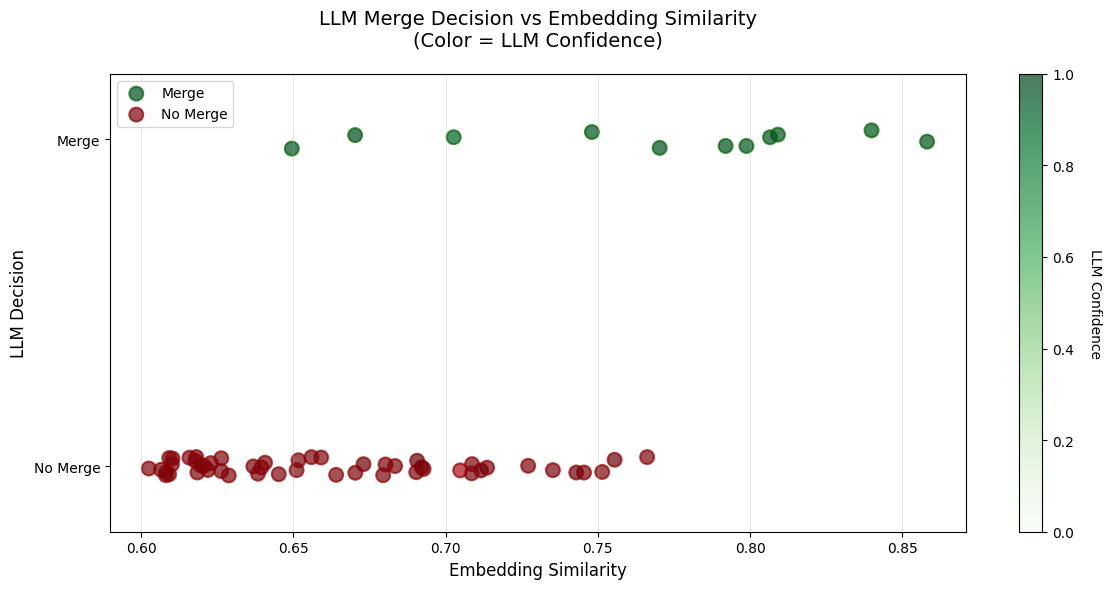


SIMILARITY SCORE ANALYSIS
Merge decisions:
  Count: 11
  Similarity range: 0.649 - 0.858
  Mean similarity: 0.768 ± 0.065

No-merge decisions:
  Count: 50
  Similarity range: 0.603 - 0.766
  Mean similarity: 0.662 ± 0.047


In [29]:
# Cell 58: Plot merge decision vs similarity score
import matplotlib.pyplot as plt

# Extract data for plotting
similarities = [r['embedding_similarity'] for r in llm_results]
merge_decisions = [1 if r['llm_decision'] else 0 for r in llm_results]
confidences = [r['llm_confidence'] for r in llm_results]

# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 6))

# Separate merge and no-merge decisions
merge_sims = [s for s, d in zip(similarities, merge_decisions) if d == 1]
merge_confs = [c for c, d in zip(confidences, merge_decisions) if d == 1]
no_merge_sims = [s for s, d in zip(similarities, merge_decisions) if d == 0]
no_merge_confs = [c for c, d in zip(confidences, merge_decisions) if d == 0]

# Plot with confidence as color intensity
scatter_merge = ax.scatter(
    merge_sims, 
    [1] * len(merge_sims),
    c=merge_confs,
    cmap='Greens',
    s=100,
    alpha=0.7,
    vmin=0,
    vmax=1,
    label='Merge',
    edgecolors='darkgreen',
    linewidth=1.5
)

scatter_no_merge = ax.scatter(
    no_merge_sims,
    [0] * len(no_merge_sims),
    c=no_merge_confs,
    cmap='Reds',
    s=100,
    alpha=0.7,
    vmin=0,
    vmax=1,
    label='No Merge',
    edgecolors='darkred',
    linewidth=1.5
)

# Add colorbar
cbar = plt.colorbar(scatter_merge, ax=ax)
cbar.set_label('LLM Confidence', rotation=270, labelpad=20)

# Styling
ax.set_xlabel('Embedding Similarity', fontsize=12)
ax.set_ylabel('LLM Decision', fontsize=12)
ax.set_yticks([0, 1])
ax.set_yticklabels(['No Merge', 'Merge'])
ax.set_title('LLM Merge Decision vs Embedding Similarity\n(Color = LLM Confidence)', fontsize=14, pad=20)
ax.grid(True, alpha=0.3, axis='x')
ax.legend(loc='upper left')

# Add some jitter to y-axis for better visibility
import numpy as np
np.random.seed(42)
jitter = 0.03
y_merge = np.ones(len(merge_sims)) + np.random.uniform(-jitter, jitter, len(merge_sims))
y_no_merge = np.zeros(len(no_merge_sims)) + np.random.uniform(-jitter, jitter, len(no_merge_sims))

# Redraw with jitter
ax.clear()
scatter_merge = ax.scatter(
    merge_sims, 
    y_merge,
    c=merge_confs,
    cmap='Greens',
    s=100,
    alpha=0.7,
    vmin=0,
    vmax=1,
    label='Merge',
    edgecolors='darkgreen',
    linewidth=1.5
)

scatter_no_merge = ax.scatter(
    no_merge_sims,
    y_no_merge,
    c=no_merge_confs,
    cmap='Reds',
    s=100,
    alpha=0.7,
    vmin=0,
    vmax=1,
    label='No Merge',
    edgecolors='darkred',
    linewidth=1.5
)

ax.set_xlabel('Embedding Similarity', fontsize=12)
ax.set_ylabel('LLM Decision', fontsize=12)
ax.set_yticks([0, 1])
ax.set_yticklabels(['No Merge', 'Merge'])
ax.set_ylim(-0.2, 1.2)
ax.set_title('LLM Merge Decision vs Embedding Similarity\n(Color = LLM Confidence)', fontsize=14, pad=20)
ax.grid(True, alpha=0.3, axis='x')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 80)
print("SIMILARITY SCORE ANALYSIS")
print("=" * 80)
if merge_sims:
    print(f"Merge decisions:")
    print(f"  Count: {len(merge_sims)}")
    print(f"  Similarity range: {min(merge_sims):.3f} - {max(merge_sims):.3f}")
    print(f"  Mean similarity: {np.mean(merge_sims):.3f} ± {np.std(merge_sims):.3f}")

if no_merge_sims:
    print(f"\nNo-merge decisions:")
    print(f"  Count: {len(no_merge_sims)}")
    print(f"  Similarity range: {min(no_merge_sims):.3f} - {max(no_merge_sims):.3f}")
    print(f"  Mean similarity: {np.mean(no_merge_sims):.3f} ± {np.std(no_merge_sims):.3f}")


In [30]:
# Cell 60: Build normalized entities and relationships from LLM merge decisions

## Step 1: Find connected components (entities involved in merges)

from collections import defaultdict

def find_merge_groups(llm_results: list[dict]) -> dict:
    """
    Find groups of entities that should be merged together.
    Returns dict: representative_entity_id -> list of entity_ids in group
    """
    # Build adjacency list of merge decisions
    merge_pairs = []
    for result in llm_results:
        if result['llm_decision']:
            merge_pairs.append((result['entity1'].id, result['entity2'].id))
    
    print(f"Found {len(merge_pairs)} pairwise merge decisions")
    
    # Find connected components using simple graph traversal
    entity_to_group = {}
    groups = []
    
    for e1_id, e2_id in merge_pairs:
        # Check if either entity is already in a group
        group1 = entity_to_group.get(e1_id)
        group2 = entity_to_group.get(e2_id)
        
        if group1 is None and group2 is None:
            # Create new group
            new_group = {e1_id, e2_id}
            groups.append(new_group)
            entity_to_group[e1_id] = new_group
            entity_to_group[e2_id] = new_group
        elif group1 is not None and group2 is None:
            # Add e2 to e1's group
            group1.add(e2_id)
            entity_to_group[e2_id] = group1
        elif group1 is None and group2 is not None:
            # Add e1 to e2's group
            group2.add(e1_id)
            entity_to_group[e1_id] = group2
        elif group1 is not group2:
            # Merge two groups
            group1.update(group2)
            for eid in group2:
                entity_to_group[eid] = group1
            groups.remove(group2)
    
    print(f"Found {len(groups)} connected components")
    for i, group in enumerate(groups, 1):
        if len(group) > 2:
            print(f"  Group {i}: {len(group)} entities (needs LLM re-evaluation)")
        else:
            print(f"  Group {i}: {len(group)} entities")
    
    return groups

merge_groups = find_merge_groups(llm_results)

# Show groups that need re-evaluation
large_groups = [g for g in merge_groups if len(g) > 2]
print(f"\n{len(large_groups)} groups with >2 entities need re-evaluation")


Found 11 pairwise merge decisions
Found 5 connected components
  Group 1: 4 entities (needs LLM re-evaluation)
  Group 2: 2 entities
  Group 3: 2 entities
  Group 4: 3 entities (needs LLM re-evaluation)
  Group 5: 2 entities

2 groups with >2 entities need re-evaluation


In [31]:
# Cell 61: LLM re-evaluation for groups with >2 entities

def reevaluate_large_groups(groups: list[set], entities_with_ids: list[EntityWithId], chain) -> list[set]:
    """
    For groups with >2 entities, use LLM to confirm all pairwise merges.
    Returns refined groups where all pairwise merges are confirmed.
    """
    entity_id_to_obj = {e.id: e for e in entities_with_ids}
    refined_groups = []
    
    for group in groups:
        if len(group) <= 2:
            # No re-evaluation needed for pairs
            refined_groups.append(group)
            continue
        
        print(f"\n{'='*80}")
        print(f"Re-evaluating group of {len(group)} entities")
        entity_list = [entity_id_to_obj[eid] for eid in group]
        for e in entity_list:
            print(f"  - {e.name} ({e.type})")
        
        # Test all pairwise combinations in this group
        confirmed_pairs = []
        entity_ids = list(group)
        
        for i in range(len(entity_ids)):
            for j in range(i + 1, len(entity_ids)):
                e1 = entity_id_to_obj[entity_ids[i]]
                e2 = entity_id_to_obj[entity_ids[j]]
                
                print(f"\n  Testing: {e1.name} <-> {e2.name}...", end=" ")
                decision = decide_entity_merge(e1, e2, chain)
                
                if decision.should_merge:
                    print(f"✓ MERGE (confidence: {decision.confidence:.2f})")
                    confirmed_pairs.append((entity_ids[i], entity_ids[j]))
                else:
                    print(f"✗ SEPARATE (confidence: {decision.confidence:.2f})")
                    print(f"     Reasoning: {decision.reasoning}")
        
        # Rebuild connected components from confirmed pairs
        if not confirmed_pairs:
            # No confirmed merges - keep as separate entities
            for eid in entity_ids:
                refined_groups.append({eid})
        else:
            # Build new connected components from confirmed pairs
            entity_to_subgroup = {}
            subgroups = []
            
            for e1_id, e2_id in confirmed_pairs:
                g1 = entity_to_subgroup.get(e1_id)
                g2 = entity_to_subgroup.get(e2_id)
                
                if g1 is None and g2 is None:
                    new_subgroup = {e1_id, e2_id}
                    subgroups.append(new_subgroup)
                    entity_to_subgroup[e1_id] = new_subgroup
                    entity_to_subgroup[e2_id] = new_subgroup
                elif g1 is not None and g2 is None:
                    g1.add(e2_id)
                    entity_to_subgroup[e2_id] = g1
                elif g1 is None and g2 is not None:
                    g2.add(e1_id)
                    entity_to_subgroup[e1_id] = g2
                elif g1 is not g2:
                    g1.update(g2)
                    for eid in g2:
                        entity_to_subgroup[eid] = g1
                    subgroups.remove(g2)
            
            # Add entities that weren't in any confirmed pair
            for eid in entity_ids:
                if eid not in entity_to_subgroup:
                    subgroups.append({eid})
            
            refined_groups.extend(subgroups)
            print(f"\n  → Split into {len(subgroups)} subgroups")
    
    return refined_groups

# Only run re-evaluation if there are large groups
if large_groups:
    print("Re-evaluating large groups...")
    refined_groups = reevaluate_large_groups(merge_groups, entities_with_ids, merge_chain)
else:
    print("No large groups - skipping re-evaluation")
    refined_groups = merge_groups

print(f"\n{'='*80}")
print(f"Final: {len(refined_groups)} merge groups after re-evaluation")


Re-evaluating large groups...

Re-evaluating group of 4 entities
  - Rome (place)
  - Rome (place)
  - Rome (place)
  - Rome (place)

  Testing: Rome <-> Rome... ✓ MERGE (confidence: 0.95)

  Testing: Rome <-> Rome... ✓ MERGE (confidence: 0.95)

  Testing: Rome <-> Rome... ✓ MERGE (confidence: 0.95)

  Testing: Rome <-> Rome... ✓ MERGE (confidence: 0.95)

  Testing: Rome <-> Rome... ✓ MERGE (confidence: 0.95)

  Testing: Rome <-> Rome... ✓ MERGE (confidence: 0.95)

  → Split into 1 subgroups

Re-evaluating group of 3 entities
  - Roman Republic (cultural)
  - Roman power (collective_entity)
  - early republic (collective_entity)

  Testing: Roman Republic <-> Roman power... ✓ MERGE (confidence: 0.95)

  Testing: Roman Republic <-> early republic... ✓ MERGE (confidence: 0.95)

  Testing: Roman power <-> early republic... ✓ MERGE (confidence: 0.90)

  → Split into 1 subgroups

Final: 5 merge groups after re-evaluation


In [32]:
# Cell 62: Update relationship models to preserve original entity names

# Add new fields to RelationshipWithId for original names
class RelationshipWithIdExtended(BaseModel):
    """Relationship with original entity names preserved."""
    id: str  # UUID
    source_id: str  # Entity UUID
    target_id: str  # Entity UUID
    source_entity_name: str  # Original entity name from extraction
    target_entity_name: str  # Original entity name from extraction
    relation_type: str
    temporal_context: Optional[str] = None
    confidence: float = Field(default=1.0, ge=0.0, le=1.0)
    paragraph_id: str

# Add new fields to NormalizedRelationship for original names
class NormalizedRelationshipExtended(BaseModel):
    """Normalized relationship with canonical entity IDs but original names preserved."""
    id: str  # UUID (preserved from original)
    source_id: str  # Normalized entity ID
    target_id: str  # Normalized entity ID
    source_entity_name: str  # Original entity name (NOT normalized name)
    target_entity_name: str  # Original entity name (NOT normalized name)
    relation_type: str
    temporal_context: Optional[str] = None
    confidence: float
    paragraph_id: str

# Convert existing relationships to extended format
entity_id_to_name = {e.id: e.name for e in entities_with_ids}

relationships_extended = []
for rel in relationships_with_ids:
    rel_ext = RelationshipWithIdExtended(
        id=rel.id,
        source_id=rel.source_id,
        target_id=rel.target_id,
        source_entity_name=entity_id_to_name.get(rel.source_id, "Unknown"),
        target_entity_name=entity_id_to_name.get(rel.target_id, "Unknown"),
        relation_type=rel.relation_type,
        temporal_context=rel.temporal_context,
        confidence=rel.confidence,
        paragraph_id=rel.paragraph_id
    )
    relationships_extended.append(rel_ext)

print(f"✓ Created {len(relationships_extended)} relationships with original entity names preserved")
print(f"\nExample relationship:")
ex = relationships_extended[0]
print(f"  {ex.source_entity_name} --[{ex.relation_type}]--> {ex.target_entity_name}")
print(f"  Source ID: {ex.source_id}")
print(f"  Target ID: {ex.target_id}")


✓ Created 32 relationships with original entity names preserved

Example relationship:
  Etruscans --[located-on]--> River Tiber
  Source ID: 2fbdec7d-1f4f-406c-8ed8-de514cf0ee85
  Target ID: 61559229-93fc-4e02-b816-d41129838ee3


In [70]:
def build_knowledge_graph_llm(
    normalized_entities: list[NormalizedEntity],
    normalized_relationships: list[NormalizedRelationshipExtended]
) -> nx.DiGraph:
    """
    Build NetworkX directed graph from LLM-normalized entities and relationships.
    
    Args:
        normalized_entities: List of NormalizedEntity objects
        normalized_relationships: List of NormalizedRelationshipExtended objects
    
    Returns:
        nx.DiGraph with nodes (entities) and edges (relationships)
    """
    G = nx.DiGraph()
    
    # Add nodes for entities
    for entity in normalized_entities:
        G.add_node(
            entity.id,
            name=entity.name,
            entity_type=entity.type,
            subtype=entity.subtype,
            aliases=entity.aliases,
            description=entity.description,
            occurrence_count=entity.occurrence_count,
            relationship_ids=entity.relationship_ids,
            merged_from_ids=entity.merged_from_ids,
            paragraph_ids=entity.source_paragraph_ids
        )
    
    print(f"Added {G.number_of_nodes()} nodes to graph")
    
    # Add edges for relationships
    for rel in normalized_relationships:
        if rel.source_id in G and rel.target_id in G:
            # Check if edge already exists (from another relationship)
            if G.has_edge(rel.source_id, rel.target_id):
                # Aggregate relation types
                edge_data = G[rel.source_id][rel.target_id]
                if rel.relation_type not in edge_data.get('relation_types', []):
                    edge_data.setdefault('relation_types', []).append(rel.relation_type)
                    # Also aggregate original entity name pairs
                    edge_data.setdefault('original_name_pairs', []).append(
                        (rel.source_entity_name, rel.target_entity_name)
                    )
            else:
                # New edge
                G.add_edge(
                    rel.source_id,
                    rel.target_id,
                    relation_id=rel.id,
                    relation_type=rel.relation_type,
                    relation_types=[rel.relation_type],
                    temporal_context=rel.temporal_context,
                    confidence=rel.confidence,
                    source_paragraph=rel.paragraph_id,
                    # Store original entity names
                    source_entity_name=rel.source_entity_name,
                    target_entity_name=rel.target_entity_name,
                    original_name_pairs=[(rel.source_entity_name, rel.target_entity_name)]
                )
    
    print(f"Added {G.number_of_edges()} edges to graph")
    
    return G

# Build the LLM-normalized graph
kg_llm = build_knowledge_graph_llm(llm_normalized_entities, llm_normalized_relationships)

# Display graph statistics
print("\n" + "=" * 80)
print("LLM-NORMALIZED KNOWLEDGE GRAPH STATISTICS")
print("=" * 80)
print(f"Total nodes (entities): {kg_llm.number_of_nodes()}")
print(f"Total edges (relationships): {kg_llm.number_of_edges()}")
print(f"Graph density: {nx.density(kg_llm):.4f}")
print(f"Is directed: {kg_llm.is_directed()}")

# Node degree statistics
degrees = [d for n, d in kg_llm.degree()]
in_degrees = [d for n, d in kg_llm.in_degree()]
out_degrees = [d for n, d in kg_llm.out_degree()]

print(f"\nAverage degree: {sum(degrees) / len(degrees):.2f}")
print(f"Average in-degree: {sum(in_degrees) / len(in_degrees):.2f}")
print(f"Average out-degree: {sum(out_degrees) / len(out_degrees):.2f}")

# Top connected entities
print("\nTop 10 most connected entities (by total degree):")
top_nodes = sorted(kg_llm.degree(), key=lambda x: x[1], reverse=True)[:10]
for node_id, degree in top_nodes:
    node_data = kg_llm.nodes[node_id]
    print(f"  {node_data['name']:30s} | degree: {degree:2d} | type: {node_data['entity_type']}")


Added 32 nodes to graph
Added 26 edges to graph

LLM-NORMALIZED KNOWLEDGE GRAPH STATISTICS
Total nodes (entities): 32
Total edges (relationships): 26
Graph density: 0.0262
Is directed: True

Average degree: 1.62
Average in-degree: 0.81
Average out-degree: 0.81

Top 10 most connected entities (by total degree):
  Rome                           | degree:  7 | type: place
  Augustus                       | degree:  6 | type: person
  Caesar                         | degree:  4 | type: person
  Etruscans                      | degree:  3 | type: collective_entity
  Parthia                        | degree:  3 | type: collective_entity
  Trajan                         | degree:  3 | type: person
  Roman Senate                   | degree:  2 | type: collective_entity
  River Tiber                    | degree:  2 | type: place
  Latins                         | degree:  2 | type: collective_entity
  Roman standards                | degree:  2 | type: cultural


In [72]:
def visualize_with_pyvis_llm(
    G: nx.DiGraph,
    normalized_entities: list[NormalizedEntity],
    normalized_relationships: list[NormalizedRelationshipExtended],
    output_file: str = "knowledge_graph_llm.html",
    height: str = "900px",
    width: str = "100%"
):
    """
    Create interactive PyVis visualization for LLM-normalized graph.
    Shows ORIGINAL entity names on relationship edges as requested.
    
    Args:
        G: NetworkX DiGraph
        normalized_entities: List of NormalizedEntity objects
        normalized_relationships: List of NormalizedRelationshipExtended objects
        output_file: HTML file to save
        height: Canvas height
        width: Canvas width
    """
    # Create PyVis network
    net = Network(
        height=height,
        width=width,
        directed=True,
        notebook=True,
        bgcolor="#F8F9FA",
        font_color="#333333"
    )
    
    # Configure physics for better layout
    net.set_options("""
    {
        "physics": {
            "enabled": true,
            "forceAtlas2Based": {
                "gravitationalConstant": -50,
                "centralGravity": 0.01,
                "springLength": 200,
                "springConstant": 0.08
            },
            "maxVelocity": 50,
            "solver": "forceAtlas2Based",
            "timestep": 0.35,
            "stabilization": {"iterations": 150}
        },
        "interaction": {
            "hover": true,
            "tooltipDelay": 100,
            "navigationButtons": true,
            "keyboard": true
        }
    }
    """)
    
    # Define colors for entity types
    type_colors = {
        'person': '#FF6B6B',
        'place': '#4ECDC4',
        'collective_entity': '#45B7D1',
        'event': '#FFA07A',
        'temporal': '#98D8C8',
        'cultural': '#C7CEEA',
    }
    
    # Create entity ID lookup
    entity_lookup = {e.id: e for e in normalized_entities}
    
    # Add nodes
    for entity in normalized_entities:
        color = type_colors.get(entity.type, '#CCCCCC')
        size = 15 + (entity.occurrence_count * 5)
        
        # Build title (hover text)
        title = f"<b>{entity.name}</b><br>"
        title += f"Type: {entity.type}"
        if entity.subtype:
            title += f" ({entity.subtype})"
        title += f"<br>Occurrences: {entity.occurrence_count}"
        title += f"<br>Relationships: {len(entity.relationship_ids)}"
        if entity.aliases:
            title += f"<br>Aliases: {', '.join(entity.aliases[:3])}"
        if entity.description:
            desc_preview = entity.description[:150] + "..." if len(entity.description) > 150 else entity.description
            title += f"<br><br>{desc_preview}"
        if entity.merged_from_ids:
            title += f"<br><br>Merged from {len(entity.merged_from_ids)} entities"
        
        net.add_node(
            entity.id,
            label=entity.name,
            title=title,
            color=color,
            size=size,
            font={'size': 14, 'face': 'Arial'},
            borderWidth=2
        )
    
    # Add edges with ORIGINAL entity names as labels
    for rel in normalized_relationships:
        if rel.source_id in entity_lookup and rel.target_id in entity_lookup:
            # Create edge label showing ORIGINAL entity names and relation type
            label = f"{rel.source_entity_name} → {rel.target_entity_name}"
            label += f"\\n{rel.relation_type.replace('-', ' ').replace('_', ' ')}"
            
            # Create title with more details
            title = f"{rel.source_entity_name} → {rel.target_entity_name}<br>"
            title += f"Relationship: {rel.relation_type}<br>"
            title += f"Normalized: {entity_lookup[rel.source_id].name} → {entity_lookup[rel.target_id].name}"
            if rel.temporal_context:
                title += f"<br>When: {rel.temporal_context}"
            
            net.add_edge(
                rel.source_id,
                rel.target_id,
                label=label,
                title=title,
                arrows='to',
                color={'color': '#888888', 'highlight': '#333333'},
                width=2,
                font={'size': 10, 'align': 'middle'}
            )
    
    # Save
    net.save_graph(output_file)
    print(f"✅ Interactive LLM-normalized graph saved to: {output_file}")
    print("\nFeatures:")
    print("  • Drag nodes to rearrange")
    print("  • Click node to highlight connections")
    print("  • Hover over nodes/edges for details")
    print("  • Edge labels show ORIGINAL entity names (not normalized)")
    print("  • Scroll to zoom, drag canvas to pan")
    print("  • Use navigation buttons (bottom right)")
    
    return net

# Create the visualization
net_llm = visualize_with_pyvis_llm(
    kg_llm,
    llm_normalized_entities,
    llm_normalized_relationships,
    output_file="knowledge_graph_llm_normalized.html"
)


✅ Interactive LLM-normalized graph saved to: knowledge_graph_llm_normalized.html

Features:
  • Drag nodes to rearrange
  • Click node to highlight connections
  • Hover over nodes/edges for details
  • Edge labels show ORIGINAL entity names (not normalized)
  • Scroll to zoom, drag canvas to pan
  • Use navigation buttons (bottom right)


In [74]:
# from IPython.display import IFrame

# # Display the interactive graph
# IFrame("knowledge_graph_llm_normalized.html", width="100%", height="900px")
